## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [5]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 100 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [9]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [10]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [11]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [12]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [13]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [14]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [16]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [17]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [18]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [19]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

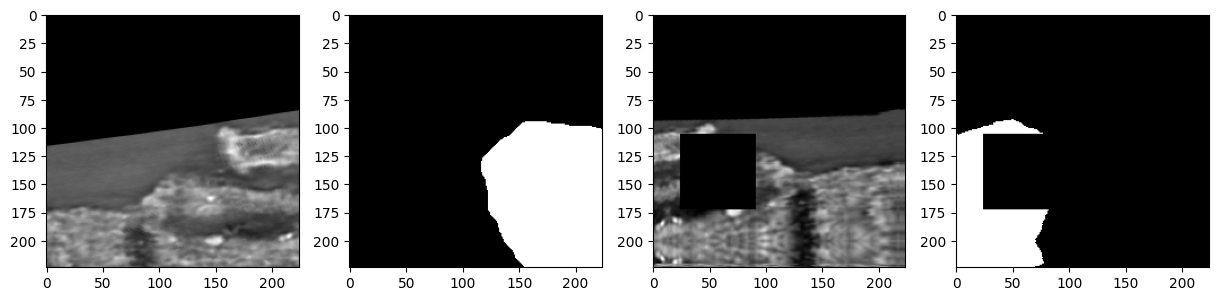

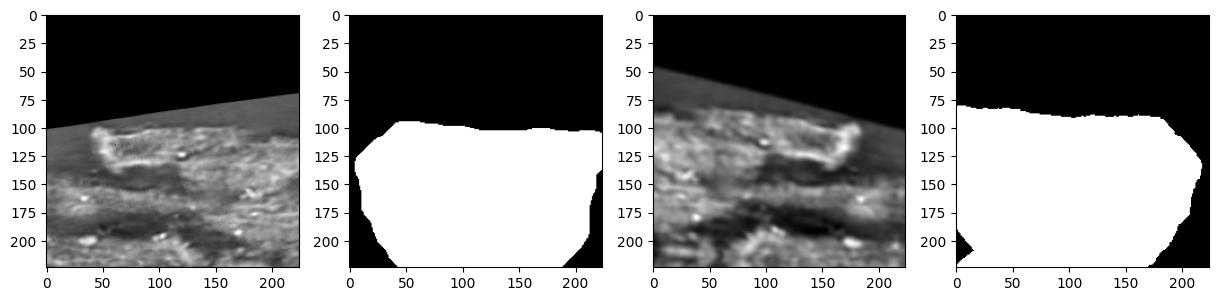

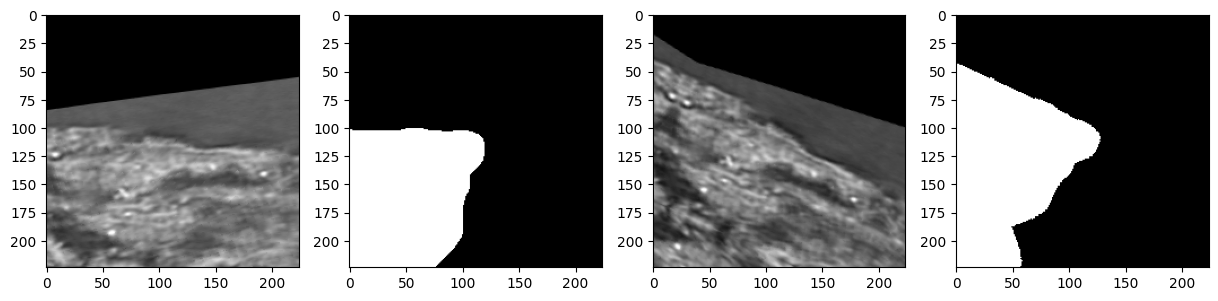

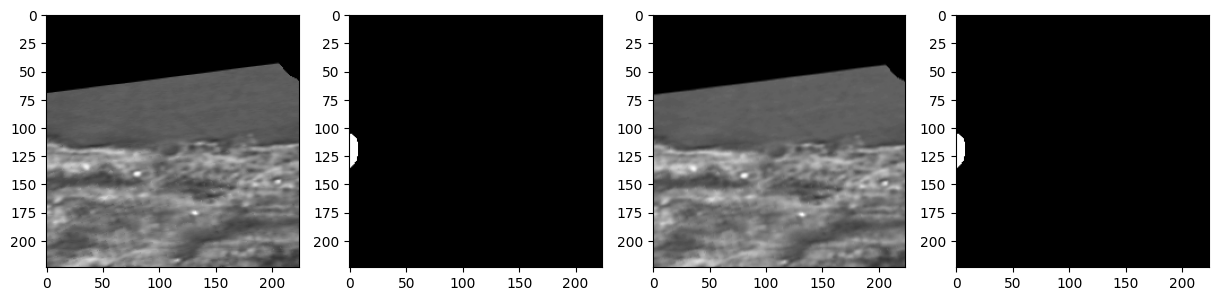

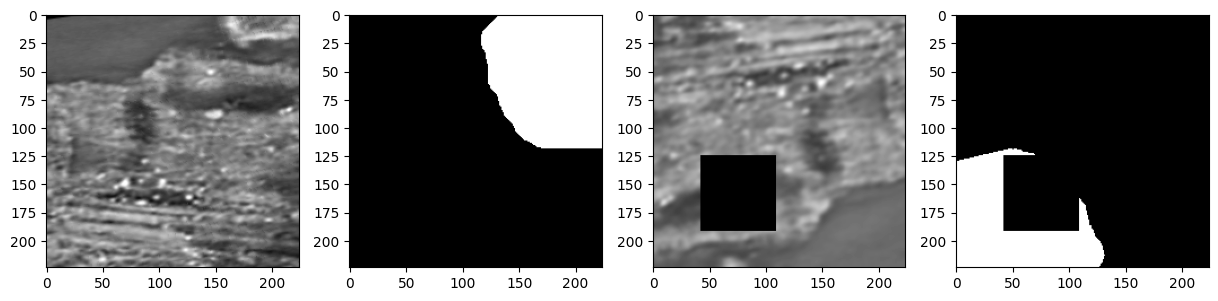

In [20]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [21]:
del plot_dataset
gc.collect()

54027

## model

In [22]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [23]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [24]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [25]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    return bce_loss
    
    y_preds_probas = torch.sigmoid(y_pred)
    dxx = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-1) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)
    dyy = torch.pow(torch.roll(y_preds_probas, shifts=-1, dims=-2) - 2*y_preds_probas + torch.roll(y_preds_probas, shifts=1, dims=-2), 2)

    # Average over all pixels
    kin_energy = torch.mean(dxx + dyy)

    
    return bce_loss + kin_energy
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [26]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [27]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 55+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [28]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [29]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501540940200977
th: 0.15, fbeta: 0.09503177981067677
th: 0.2, fbeta: 0.13790535695175213
th: 0.25, fbeta: 0.15388678812369985
th: 0.3, fbeta: 0.16274534237460228
th: 0.35, fbeta: 0.17470614474888477
th: 0.4, fbeta: 0.1837630883788759
th: 0.45, fbeta: 0.1773647157323217


best_th: 0.4, fbeta: 0.1837630883788759
Epoch 1 - avg_train_loss: 0.6095  avg_val_loss: 0.4173  time: 27s
Epoch 1 - avgScore: 0.1838
Epoch 1 - Save Best Score: 0.1838 Model
Epoch 1 - Save Best Loss: 0.4173 Model


th: 0.5, fbeta: 0.12883651344826025
th: 0.55, fbeta: 0.0530374349768504


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09511751923285533
th: 0.15, fbeta: 0.15184185813814982
th: 0.2, fbeta: 0.17749295901629314
th: 0.25, fbeta: 0.22208605779465035
th: 0.3, fbeta: 0.26290266672339985
th: 0.35, fbeta: 0.301176818201802
th: 0.4, fbeta: 0.33192958456213656
th: 0.45, fbeta: 0.3262306281095702
th: 0.5, fbeta: 0.22062778354919926


best_th: 0.4, fbeta: 0.33192958456213656
Epoch 2 - avg_train_loss: 0.3842  avg_val_loss: 0.3182  time: 27s
Epoch 2 - avgScore: 0.3319
Epoch 2 - Save Best Score: 0.3319 Model
Epoch 2 - Save Best Loss: 0.3182 Model


th: 0.55, fbeta: 0.06649188941274206


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.2489197523973447
th: 0.15, fbeta: 0.35498239358952055
th: 0.2, fbeta: 0.4336456804361015
th: 0.25, fbeta: 0.48107912744991405
th: 0.3, fbeta: 0.5080054223615049
th: 0.35, fbeta: 0.5186851204940182
th: 0.4, fbeta: 0.517111055666539
th: 0.45, fbeta: 0.49318045759208934
th: 0.5, fbeta: 0.44159930526016405


best_th: 0.35, fbeta: 0.5186851204940182
Epoch 3 - avg_train_loss: 0.2844  avg_val_loss: 0.1992  time: 54s
Epoch 3 - avgScore: 0.5187
Epoch 3 - Save Best Score: 0.5187 Model
Epoch 3 - Save Best Loss: 0.1992 Model


th: 0.55, fbeta: 0.3432918530376234


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23069893881619552
th: 0.15, fbeta: 0.28266159767796
th: 0.2, fbeta: 0.3300946590450215
th: 0.25, fbeta: 0.3709708088792733
th: 0.3, fbeta: 0.40569331420659366
th: 0.35, fbeta: 0.4386085893048984
th: 0.4, fbeta: 0.47063566717041405
th: 0.45, fbeta: 0.4982257386279732
th: 0.5, fbeta: 0.5148711558465336


best_th: 0.55, fbeta: 0.5167559541550584
Epoch 4 - avg_train_loss: 0.2590  avg_val_loss: 0.2040  time: 86s
Epoch 4 - avgScore: 0.5168


th: 0.55, fbeta: 0.5167559541550584


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.226125817396298
th: 0.15, fbeta: 0.27408962360645983
th: 0.2, fbeta: 0.3195065883022912
th: 0.25, fbeta: 0.35995606566884136
th: 0.3, fbeta: 0.397700864830191
th: 0.35, fbeta: 0.4300229746423469
th: 0.4, fbeta: 0.45841573220514564
th: 0.45, fbeta: 0.48197055564041347
th: 0.5, fbeta: 0.502287551620135


best_th: 0.55, fbeta: 0.513346516058544
Epoch 5 - avg_train_loss: 0.2447  avg_val_loss: 0.2087  time: 89s
Epoch 5 - avgScore: 0.5133


th: 0.55, fbeta: 0.513346516058544


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2728670128089458
th: 0.15, fbeta: 0.317170363906437
th: 0.2, fbeta: 0.35619916658664513
th: 0.25, fbeta: 0.38927140906911195
th: 0.3, fbeta: 0.4184463990588853
th: 0.35, fbeta: 0.4461573433699022
th: 0.4, fbeta: 0.47221551653810906
th: 0.45, fbeta: 0.49705588395581807
th: 0.5, fbeta: 0.5191337720651662


best_th: 0.55, fbeta: 0.5319217960855315
Epoch 6 - avg_train_loss: 0.2388  avg_val_loss: 0.2014  time: 104s
Epoch 6 - avgScore: 0.5319
Epoch 6 - Save Best Score: 0.5319 Model
Epoch 6 - Save Best Loss: 0.2014 Model


th: 0.55, fbeta: 0.5319217960855315


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2175539822523473
th: 0.15, fbeta: 0.24862886890068972
th: 0.2, fbeta: 0.27783823716417494
th: 0.25, fbeta: 0.30723848474006
th: 0.3, fbeta: 0.33595496136010666
th: 0.35, fbeta: 0.3637735609529489
th: 0.4, fbeta: 0.3905422562464972
th: 0.45, fbeta: 0.41682622546249337
th: 0.5, fbeta: 0.4449458469237959


best_th: 0.55, fbeta: 0.4756936475356487
Epoch 7 - avg_train_loss: 0.2325  avg_val_loss: 0.2364  time: 70s
Epoch 7 - avgScore: 0.4757


th: 0.55, fbeta: 0.4756936475356487


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29374247166998363
th: 0.15, fbeta: 0.348916311289744
th: 0.2, fbeta: 0.4002902415696631
th: 0.25, fbeta: 0.44454058860575424
th: 0.3, fbeta: 0.4839779508929237
th: 0.35, fbeta: 0.5181179837557308
th: 0.4, fbeta: 0.536468377166927
th: 0.45, fbeta: 0.5358262972604119
th: 0.5, fbeta: 0.5235740872172282


best_th: 0.4, fbeta: 0.536468377166927
Epoch 8 - avg_train_loss: 0.2281  avg_val_loss: 0.1941  time: 88s
Epoch 8 - avgScore: 0.5365
Epoch 8 - Save Best Score: 0.5365 Model
Epoch 8 - Save Best Loss: 0.1941 Model


th: 0.55, fbeta: 0.49807045282647683


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2484912260603995
th: 0.15, fbeta: 0.2855951549567085
th: 0.2, fbeta: 0.31587681139524165
th: 0.25, fbeta: 0.3421436600426525
th: 0.3, fbeta: 0.36746780087095116
th: 0.35, fbeta: 0.3914100006895232
th: 0.4, fbeta: 0.413121227547759
th: 0.45, fbeta: 0.4350375983322281
th: 0.5, fbeta: 0.4567507674678454


best_th: 0.55, fbeta: 0.4784391313011333
Epoch 9 - avg_train_loss: 0.2207  avg_val_loss: 0.2306  time: 64s
Epoch 9 - avgScore: 0.4784


th: 0.55, fbeta: 0.4784391313011333


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2737626088373182
th: 0.15, fbeta: 0.33013075374757533
th: 0.2, fbeta: 0.3747776841427316
th: 0.25, fbeta: 0.4091117276614794
th: 0.3, fbeta: 0.4401463754538579
th: 0.35, fbeta: 0.4676601299307609
th: 0.4, fbeta: 0.49038505456900355
th: 0.45, fbeta: 0.5101138054730094
th: 0.5, fbeta: 0.5239002136937784


best_th: 0.55, fbeta: 0.5363214363299309
Epoch 10 - avg_train_loss: 0.2189  avg_val_loss: 0.2006  time: 70s
Epoch 10 - avgScore: 0.5363


th: 0.55, fbeta: 0.5363214363299309


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21607369830333042
th: 0.15, fbeta: 0.2501534707758829
th: 0.2, fbeta: 0.28278749859705427
th: 0.25, fbeta: 0.3170578259481885
th: 0.3, fbeta: 0.3503740931382896
th: 0.35, fbeta: 0.38032629708404214
th: 0.4, fbeta: 0.40722240657475695
th: 0.45, fbeta: 0.43399893130732625
th: 0.5, fbeta: 0.460904796589004


best_th: 0.55, fbeta: 0.4889270221283039
Epoch 11 - avg_train_loss: 0.2053  avg_val_loss: 0.2367  time: 83s
Epoch 11 - avgScore: 0.4889


th: 0.55, fbeta: 0.4889270221283039


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21148039644959454
th: 0.15, fbeta: 0.23975411349738396
th: 0.2, fbeta: 0.26947876064517584
th: 0.25, fbeta: 0.30120387273426646
th: 0.3, fbeta: 0.3328791730437903
th: 0.35, fbeta: 0.36394904619383284
th: 0.4, fbeta: 0.39228201545188224
th: 0.45, fbeta: 0.4201358440222766
th: 0.5, fbeta: 0.44795237254033343


best_th: 0.55, fbeta: 0.47575110953767663
Epoch 12 - avg_train_loss: 0.1999  avg_val_loss: 0.2473  time: 84s
Epoch 12 - avgScore: 0.4758


th: 0.55, fbeta: 0.47575110953767663


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27154671439961253
th: 0.15, fbeta: 0.32326599485951935
th: 0.2, fbeta: 0.3711529879177114
th: 0.25, fbeta: 0.416198804705142
th: 0.3, fbeta: 0.4567511183148342
th: 0.35, fbeta: 0.49339486190309134
th: 0.4, fbeta: 0.5212200800112577
th: 0.45, fbeta: 0.5423768790699418
th: 0.5, fbeta: 0.55304399119186


best_th: 0.55, fbeta: 0.557548783559709
Epoch 13 - avg_train_loss: 0.1983  avg_val_loss: 0.1984  time: 95s
Epoch 13 - avgScore: 0.5575
Epoch 13 - Save Best Score: 0.5575 Model
Epoch 13 - Save Best Loss: 0.1984 Model


th: 0.55, fbeta: 0.557548783559709


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31345833575347576
th: 0.15, fbeta: 0.36739218787669264
th: 0.2, fbeta: 0.4211106902846633
th: 0.25, fbeta: 0.4672812026042148
th: 0.3, fbeta: 0.5011443614535271
th: 0.35, fbeta: 0.523162255129737
th: 0.4, fbeta: 0.534634684380463
th: 0.45, fbeta: 0.5327447367366321
th: 0.5, fbeta: 0.5280576442559163


best_th: 0.4, fbeta: 0.534634684380463
Epoch 14 - avg_train_loss: 0.1947  avg_val_loss: 0.2006  time: 58s
Epoch 14 - avgScore: 0.5346


th: 0.55, fbeta: 0.5137554654844702


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22347974555767852
th: 0.15, fbeta: 0.248776727007725
th: 0.2, fbeta: 0.2762709818189519
th: 0.25, fbeta: 0.3044974051608717
th: 0.3, fbeta: 0.33572210775166256
th: 0.35, fbeta: 0.3674428761131183
th: 0.4, fbeta: 0.3987982504137846
th: 0.45, fbeta: 0.4301089079191771
th: 0.5, fbeta: 0.4565908364314962


best_th: 0.55, fbeta: 0.47847545300649746
Epoch 15 - avg_train_loss: 0.1879  avg_val_loss: 0.2432  time: 73s
Epoch 15 - avgScore: 0.4785


th: 0.55, fbeta: 0.47847545300649746


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36120456984742744
th: 0.15, fbeta: 0.4108603714057173
th: 0.2, fbeta: 0.4487698782592785
th: 0.25, fbeta: 0.47289041246208235
th: 0.3, fbeta: 0.48705238087253533
th: 0.35, fbeta: 0.49837624211750814
th: 0.4, fbeta: 0.5073497122723797
th: 0.45, fbeta: 0.5131727005138217
th: 0.5, fbeta: 0.5114583217117756


best_th: 0.45, fbeta: 0.5131727005138217
Epoch 16 - avg_train_loss: 0.1853  avg_val_loss: 0.2337  time: 99s
Epoch 16 - avgScore: 0.5132


th: 0.55, fbeta: 0.4999365785117773


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29808597001165993
th: 0.15, fbeta: 0.3349038826103707
th: 0.2, fbeta: 0.36815523090454716
th: 0.25, fbeta: 0.3985975384282319
th: 0.3, fbeta: 0.4241832818440313
th: 0.35, fbeta: 0.4456310700752995
th: 0.4, fbeta: 0.4652555541177452
th: 0.45, fbeta: 0.48298755901811485
th: 0.5, fbeta: 0.49824087657160004


best_th: 0.55, fbeta: 0.5116663956640172
Epoch 17 - avg_train_loss: 0.1814  avg_val_loss: 0.2191  time: 87s
Epoch 17 - avgScore: 0.5117


th: 0.55, fbeta: 0.5116663956640172


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29426091162638995
th: 0.15, fbeta: 0.33612263031453704
th: 0.2, fbeta: 0.37417155892518794
th: 0.25, fbeta: 0.4067538843511474
th: 0.3, fbeta: 0.4346862986372885
th: 0.35, fbeta: 0.4604849717081875
th: 0.4, fbeta: 0.48302608467321373
th: 0.45, fbeta: 0.5016433100649428
th: 0.5, fbeta: 0.5155872336738963


best_th: 0.55, fbeta: 0.5205237381348651
Epoch 18 - avg_train_loss: 0.1765  avg_val_loss: 0.2142  time: 102s
Epoch 18 - avgScore: 0.5205


th: 0.55, fbeta: 0.5205237381348651


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24389180957071707
th: 0.15, fbeta: 0.2755898815643493
th: 0.2, fbeta: 0.30470082601604986
th: 0.25, fbeta: 0.3308363853863529
th: 0.3, fbeta: 0.3561564673041168
th: 0.35, fbeta: 0.3798472258832417
th: 0.4, fbeta: 0.4030347480742102
th: 0.45, fbeta: 0.42709309080737706
th: 0.5, fbeta: 0.44860526866696876


best_th: 0.55, fbeta: 0.46997876607033257
Epoch 19 - avg_train_loss: 0.1703  avg_val_loss: 0.2450  time: 106s
Epoch 19 - avgScore: 0.4700


th: 0.55, fbeta: 0.46997876607033257


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2892602320587033
th: 0.15, fbeta: 0.3238606160705287
th: 0.2, fbeta: 0.3527959251313252
th: 0.25, fbeta: 0.378897306995934
th: 0.3, fbeta: 0.40154326449370276
th: 0.35, fbeta: 0.4225771764659655
th: 0.4, fbeta: 0.44449214598572284
th: 0.45, fbeta: 0.4654946545989494
th: 0.5, fbeta: 0.4833310051936365


best_th: 0.55, fbeta: 0.49733320307368456
Epoch 20 - avg_train_loss: 0.1660  avg_val_loss: 0.2275  time: 99s
Epoch 20 - avgScore: 0.4973


th: 0.55, fbeta: 0.49733320307368456


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2585913525946358
th: 0.15, fbeta: 0.28978011033957735
th: 0.2, fbeta: 0.31838320112677415
th: 0.25, fbeta: 0.34581943091664236
th: 0.3, fbeta: 0.3718823329284863
th: 0.35, fbeta: 0.3974288022365033
th: 0.4, fbeta: 0.41951478692235966
th: 0.45, fbeta: 0.43828443854634164
th: 0.5, fbeta: 0.4537906122344925


best_th: 0.55, fbeta: 0.46688231431808447
Epoch 21 - avg_train_loss: 0.1626  avg_val_loss: 0.2396  time: 76s
Epoch 21 - avgScore: 0.4669


th: 0.55, fbeta: 0.46688231431808447


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2832741189431183
th: 0.15, fbeta: 0.3109212196738607
th: 0.2, fbeta: 0.3337335150174003
th: 0.25, fbeta: 0.3583603386727801
th: 0.3, fbeta: 0.3803202083966331
th: 0.35, fbeta: 0.397638753529287
th: 0.4, fbeta: 0.4110263817662737
th: 0.45, fbeta: 0.41803449447012125
th: 0.5, fbeta: 0.4255296058852877


best_th: 0.55, fbeta: 0.4350297751703394
Epoch 22 - avg_train_loss: 0.1618  avg_val_loss: 0.2493  time: 94s
Epoch 22 - avgScore: 0.4350


th: 0.55, fbeta: 0.4350297751703394


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2741957457094549
th: 0.15, fbeta: 0.307702333220288
th: 0.2, fbeta: 0.33730753841536915
th: 0.25, fbeta: 0.36660234104555484
th: 0.3, fbeta: 0.3899490732238787
th: 0.35, fbeta: 0.411362065206441
th: 0.4, fbeta: 0.4331228150173816
th: 0.45, fbeta: 0.4543000056110375
th: 0.5, fbeta: 0.47334604883965614


best_th: 0.55, fbeta: 0.48877267878487196
Epoch 23 - avg_train_loss: 0.1580  avg_val_loss: 0.2443  time: 77s
Epoch 23 - avgScore: 0.4888


th: 0.55, fbeta: 0.48877267878487196


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2505949596329454
th: 0.15, fbeta: 0.2837247606572715
th: 0.2, fbeta: 0.3179733796319882
th: 0.25, fbeta: 0.3506402074249056
th: 0.3, fbeta: 0.3799695942559987
th: 0.35, fbeta: 0.4064029555529731
th: 0.4, fbeta: 0.4303770803351769
th: 0.45, fbeta: 0.4526810535614112
th: 0.5, fbeta: 0.4759526976107674


best_th: 0.55, fbeta: 0.49682075626484673
Epoch 24 - avg_train_loss: 0.1531  avg_val_loss: 0.2369  time: 88s
Epoch 24 - avgScore: 0.4968


th: 0.55, fbeta: 0.49682075626484673


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29666417665931305
th: 0.15, fbeta: 0.3352233302869528
th: 0.2, fbeta: 0.36784779236801984
th: 0.25, fbeta: 0.3922206672443403
th: 0.3, fbeta: 0.416179253259066
th: 0.35, fbeta: 0.4374769641810039
th: 0.4, fbeta: 0.45659281206915986
th: 0.45, fbeta: 0.47521508931013107
th: 0.5, fbeta: 0.4922746694399121


best_th: 0.55, fbeta: 0.506235944754844
Epoch 25 - avg_train_loss: 0.1508  avg_val_loss: 0.2413  time: 85s
Epoch 25 - avgScore: 0.5062


th: 0.55, fbeta: 0.506235944754844


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3017210514813274
th: 0.15, fbeta: 0.34171850584321095
th: 0.2, fbeta: 0.37331255048537904
th: 0.25, fbeta: 0.3983586093567369
th: 0.3, fbeta: 0.4192100980136497
th: 0.35, fbeta: 0.4377539095376904
th: 0.4, fbeta: 0.4529285012922979
th: 0.45, fbeta: 0.46595978958462075
th: 0.5, fbeta: 0.4814873678756441


best_th: 0.55, fbeta: 0.4928028772686992
Epoch 26 - avg_train_loss: 0.1476  avg_val_loss: 0.2346  time: 87s
Epoch 26 - avgScore: 0.4928


th: 0.55, fbeta: 0.4928028772686992


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2905469341814648
th: 0.15, fbeta: 0.3209912168652534
th: 0.2, fbeta: 0.349252124029412
th: 0.25, fbeta: 0.37452315327610014
th: 0.3, fbeta: 0.39782698210030853
th: 0.35, fbeta: 0.4199666524135221
th: 0.4, fbeta: 0.44238468067998366
th: 0.45, fbeta: 0.4619994835631486
th: 0.5, fbeta: 0.474845240820808


best_th: 0.55, fbeta: 0.4835123414444264
Epoch 27 - avg_train_loss: 0.1463  avg_val_loss: 0.2353  time: 83s
Epoch 27 - avgScore: 0.4835


th: 0.55, fbeta: 0.4835123414444264


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2954602592941305
th: 0.15, fbeta: 0.3287365290488733
th: 0.2, fbeta: 0.35845623625597645
th: 0.25, fbeta: 0.38424643036147527
th: 0.3, fbeta: 0.4087687901297978
th: 0.35, fbeta: 0.4322104634197576
th: 0.4, fbeta: 0.4500116713839195
th: 0.45, fbeta: 0.4659937572185611
th: 0.5, fbeta: 0.48160949617447113


best_th: 0.55, fbeta: 0.4932578523372827
Epoch 28 - avg_train_loss: 0.1451  avg_val_loss: 0.2449  time: 76s
Epoch 28 - avgScore: 0.4933


th: 0.55, fbeta: 0.4932578523372827


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3373751554491924
th: 0.15, fbeta: 0.37076939118459773
th: 0.2, fbeta: 0.4010602637172239
th: 0.25, fbeta: 0.42572489567205773
th: 0.3, fbeta: 0.4473847651712497
th: 0.35, fbeta: 0.46597754601475827
th: 0.4, fbeta: 0.47893172468178
th: 0.45, fbeta: 0.487526953831115
th: 0.5, fbeta: 0.49209901857499794


best_th: 0.55, fbeta: 0.4938138472846863
Epoch 29 - avg_train_loss: 0.1409  avg_val_loss: 0.2397  time: 103s
Epoch 29 - avgScore: 0.4938


th: 0.55, fbeta: 0.4938138472846863


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30962891487693706
th: 0.15, fbeta: 0.34208064456828
th: 0.2, fbeta: 0.3716024789126267
th: 0.25, fbeta: 0.39917399519612057
th: 0.3, fbeta: 0.42329673574248106
th: 0.35, fbeta: 0.44737487170886303
th: 0.4, fbeta: 0.4680119048186465
th: 0.45, fbeta: 0.48261671830772757
th: 0.5, fbeta: 0.496777427928264


best_th: 0.55, fbeta: 0.5062422996888485
Epoch 30 - avg_train_loss: 0.1367  avg_val_loss: 0.2364  time: 89s
Epoch 30 - avgScore: 0.5062


th: 0.55, fbeta: 0.5062422996888485


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2768026600630974
th: 0.15, fbeta: 0.3084722705153973
th: 0.2, fbeta: 0.33776512745407133
th: 0.25, fbeta: 0.36782061267482313
th: 0.3, fbeta: 0.39348255838887913
th: 0.35, fbeta: 0.4168319325176462
th: 0.4, fbeta: 0.43851299452915776
th: 0.45, fbeta: 0.45433822936854895
th: 0.5, fbeta: 0.46597167837119974


best_th: 0.55, fbeta: 0.47636774640675683
Epoch 31 - avg_train_loss: 0.1334  avg_val_loss: 0.2380  time: 103s
Epoch 31 - avgScore: 0.4764


th: 0.55, fbeta: 0.47636774640675683


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29357157269495354
th: 0.15, fbeta: 0.3260602311110807
th: 0.2, fbeta: 0.35621214312872423
th: 0.25, fbeta: 0.3805867826928941
th: 0.3, fbeta: 0.40088508209364215
th: 0.35, fbeta: 0.41898774136513256
th: 0.4, fbeta: 0.43607504102430894
th: 0.45, fbeta: 0.4509917074398191
th: 0.5, fbeta: 0.46567982517258305


best_th: 0.55, fbeta: 0.4732566391774681
Epoch 32 - avg_train_loss: 0.1280  avg_val_loss: 0.2523  time: 87s
Epoch 32 - avgScore: 0.4733


th: 0.55, fbeta: 0.4732566391774681


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34143959756585535
th: 0.15, fbeta: 0.3747069989065489
th: 0.2, fbeta: 0.40421990765385607
th: 0.25, fbeta: 0.4308217992195644
th: 0.3, fbeta: 0.45657138631080973
th: 0.35, fbeta: 0.4776458957275897
th: 0.4, fbeta: 0.49283120926691887
th: 0.45, fbeta: 0.506627870959307
th: 0.5, fbeta: 0.5174336904317771


best_th: 0.55, fbeta: 0.5185913933770515
Epoch 33 - avg_train_loss: 0.1295  avg_val_loss: 0.2403  time: 90s
Epoch 33 - avgScore: 0.5186


th: 0.55, fbeta: 0.5185913933770515


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29133265153638055
th: 0.15, fbeta: 0.3186152522602271
th: 0.2, fbeta: 0.34132789421655674
th: 0.25, fbeta: 0.36041030947189834
th: 0.3, fbeta: 0.37886273489982397
th: 0.35, fbeta: 0.3946660520027923
th: 0.4, fbeta: 0.40876613073445034
th: 0.45, fbeta: 0.42087380011939063
th: 0.5, fbeta: 0.4341450693222401


best_th: 0.55, fbeta: 0.4427897180188152
Epoch 34 - avg_train_loss: 0.1286  avg_val_loss: 0.2645  time: 93s
Epoch 34 - avgScore: 0.4428


th: 0.55, fbeta: 0.4427897180188152


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2564729279720899
th: 0.15, fbeta: 0.2850775619966831
th: 0.2, fbeta: 0.3123082256724569
th: 0.25, fbeta: 0.33591945520920385
th: 0.3, fbeta: 0.3563921506841998
th: 0.35, fbeta: 0.37570103302416097
th: 0.4, fbeta: 0.3942508212763787
th: 0.45, fbeta: 0.4128142278751131
th: 0.5, fbeta: 0.43143287568314115


best_th: 0.55, fbeta: 0.4491441446059089
Epoch 35 - avg_train_loss: 0.1270  avg_val_loss: 0.2742  time: 83s
Epoch 35 - avgScore: 0.4491


th: 0.55, fbeta: 0.4491441446059089


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35601897861152537
th: 0.15, fbeta: 0.38642373793289764
th: 0.2, fbeta: 0.4139436786776382
th: 0.25, fbeta: 0.4381040669875351
th: 0.3, fbeta: 0.45394306728426626
th: 0.35, fbeta: 0.46468907789767816
th: 0.4, fbeta: 0.4739658705166548
th: 0.45, fbeta: 0.4809801975511312
th: 0.5, fbeta: 0.48059022788490335


best_th: 0.45, fbeta: 0.4809801975511312
Epoch 36 - avg_train_loss: 0.1223  avg_val_loss: 0.2628  time: 81s
Epoch 36 - avgScore: 0.4810


th: 0.55, fbeta: 0.4746794717975161


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28165414398285615
th: 0.15, fbeta: 0.31334940959870927
th: 0.2, fbeta: 0.3390643752480862
th: 0.25, fbeta: 0.3619804682665914
th: 0.3, fbeta: 0.38252024241960736
th: 0.35, fbeta: 0.40213609698853126
th: 0.4, fbeta: 0.4190794172029705
th: 0.45, fbeta: 0.43710269328399065
th: 0.5, fbeta: 0.4557499807593702


best_th: 0.55, fbeta: 0.47392785278024413
Epoch 37 - avg_train_loss: 0.1186  avg_val_loss: 0.2504  time: 83s
Epoch 37 - avgScore: 0.4739


th: 0.55, fbeta: 0.47392785278024413


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3047330135522431
th: 0.15, fbeta: 0.3336097461951353
th: 0.2, fbeta: 0.3588847902677588
th: 0.25, fbeta: 0.3814798368941051
th: 0.3, fbeta: 0.4021192348992983
th: 0.35, fbeta: 0.4204135573487119
th: 0.4, fbeta: 0.43854451310209536
th: 0.45, fbeta: 0.4578473206154445
th: 0.5, fbeta: 0.47892127765998327


best_th: 0.55, fbeta: 0.49620449518017673
Epoch 38 - avg_train_loss: 0.1155  avg_val_loss: 0.2648  time: 92s
Epoch 38 - avgScore: 0.4962


th: 0.55, fbeta: 0.49620449518017673


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2780406449183141
th: 0.15, fbeta: 0.3141005142554897
th: 0.2, fbeta: 0.3464820994281011
th: 0.25, fbeta: 0.37220196561923696
th: 0.3, fbeta: 0.3958307470668721
th: 0.35, fbeta: 0.4168892574874225
th: 0.4, fbeta: 0.4380541647630093
th: 0.45, fbeta: 0.4577951459806453
th: 0.5, fbeta: 0.472680586020531


best_th: 0.55, fbeta: 0.4823976634441152
Epoch 39 - avg_train_loss: 0.1154  avg_val_loss: 0.2404  time: 90s
Epoch 39 - avgScore: 0.4824


th: 0.55, fbeta: 0.4823976634441152


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3394156675948091
th: 0.15, fbeta: 0.37708180794397744
th: 0.2, fbeta: 0.40563684698257524
th: 0.25, fbeta: 0.4315494326668037
th: 0.3, fbeta: 0.4521048811180392
th: 0.35, fbeta: 0.4711584762273869
th: 0.4, fbeta: 0.4896208623790671
th: 0.45, fbeta: 0.5049831345949805
th: 0.5, fbeta: 0.518569205968085


best_th: 0.55, fbeta: 0.5240280335915144
Epoch 40 - avg_train_loss: 0.1140  avg_val_loss: 0.2321  time: 90s
Epoch 40 - avgScore: 0.5240


th: 0.55, fbeta: 0.5240280335915144


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3464394213096939
th: 0.15, fbeta: 0.37319742867171746
th: 0.2, fbeta: 0.39708502855314637
th: 0.25, fbeta: 0.41519931810543026
th: 0.3, fbeta: 0.42808040496334204
th: 0.35, fbeta: 0.44002791924255846
th: 0.4, fbeta: 0.45017243164309145
th: 0.45, fbeta: 0.4605403884958941
th: 0.5, fbeta: 0.4674547334939633


best_th: 0.55, fbeta: 0.46993595325093307
Epoch 41 - avg_train_loss: 0.1140  avg_val_loss: 0.2657  time: 98s
Epoch 41 - avgScore: 0.4699


th: 0.55, fbeta: 0.46993595325093307


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28782408516490365
th: 0.15, fbeta: 0.32305841309786487
th: 0.2, fbeta: 0.35059144946399223
th: 0.25, fbeta: 0.37430446979547216
th: 0.3, fbeta: 0.3969749123378531
th: 0.35, fbeta: 0.416325698545995
th: 0.4, fbeta: 0.4363837027189619
th: 0.45, fbeta: 0.4537664067840513
th: 0.5, fbeta: 0.4703160428189771


best_th: 0.55, fbeta: 0.4835995204790877
Epoch 42 - avg_train_loss: 0.1134  avg_val_loss: 0.2483  time: 81s
Epoch 42 - avgScore: 0.4836


th: 0.55, fbeta: 0.4835995204790877


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3285838185736801
th: 0.15, fbeta: 0.36798140262656853
th: 0.2, fbeta: 0.3985980183828788
th: 0.25, fbeta: 0.4237002782861516
th: 0.3, fbeta: 0.4428639610449299
th: 0.35, fbeta: 0.46182339178818693
th: 0.4, fbeta: 0.47940348415922535
th: 0.45, fbeta: 0.4944267715935135
th: 0.5, fbeta: 0.5060805588292144


best_th: 0.55, fbeta: 0.5134300457125165
Epoch 43 - avg_train_loss: 0.1064  avg_val_loss: 0.2488  time: 93s
Epoch 43 - avgScore: 0.5134


th: 0.55, fbeta: 0.5134300457125165


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31595894202482605
th: 0.15, fbeta: 0.3459836592679238
th: 0.2, fbeta: 0.3711925101859259
th: 0.25, fbeta: 0.3930752243364651
th: 0.3, fbeta: 0.41019432000257805
th: 0.35, fbeta: 0.42485232496444714
th: 0.4, fbeta: 0.4430339318104679
th: 0.45, fbeta: 0.45841967448072474
th: 0.5, fbeta: 0.46827599665855235


best_th: 0.55, fbeta: 0.47604430235298906
Epoch 44 - avg_train_loss: 0.1071  avg_val_loss: 0.2630  time: 80s
Epoch 44 - avgScore: 0.4760


th: 0.55, fbeta: 0.47604430235298906


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3125420781215171
th: 0.15, fbeta: 0.34097485168779595
th: 0.2, fbeta: 0.36456580571581026
th: 0.25, fbeta: 0.38748673218288476
th: 0.3, fbeta: 0.40668863172405717
th: 0.35, fbeta: 0.42244542548915226
th: 0.4, fbeta: 0.4366674228929473
th: 0.45, fbeta: 0.45078281617697885
th: 0.5, fbeta: 0.46367117574246125


best_th: 0.55, fbeta: 0.4744265414753812
Epoch 45 - avg_train_loss: 0.1077  avg_val_loss: 0.2657  time: 89s
Epoch 45 - avgScore: 0.4744


th: 0.55, fbeta: 0.4744265414753812


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2925463064424522
th: 0.15, fbeta: 0.32445501569728863
th: 0.2, fbeta: 0.3500234551725408
th: 0.25, fbeta: 0.3742569057025737
th: 0.3, fbeta: 0.392490045616072
th: 0.35, fbeta: 0.4073713928136273
th: 0.4, fbeta: 0.421739927290342
th: 0.45, fbeta: 0.43723265899125274
th: 0.5, fbeta: 0.45248416683567094


best_th: 0.55, fbeta: 0.462478457934774
Epoch 46 - avg_train_loss: 0.1065  avg_val_loss: 0.2676  time: 104s
Epoch 46 - avgScore: 0.4625


th: 0.55, fbeta: 0.462478457934774


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3304632890686969
th: 0.15, fbeta: 0.3596331649648844
th: 0.2, fbeta: 0.38648458219185383
th: 0.25, fbeta: 0.4082545833249642
th: 0.3, fbeta: 0.43007091716797524
th: 0.35, fbeta: 0.4473122485719262
th: 0.4, fbeta: 0.4605057941158781
th: 0.45, fbeta: 0.47408433648820975
th: 0.5, fbeta: 0.4851401661455712


best_th: 0.55, fbeta: 0.4921488887673409
Epoch 47 - avg_train_loss: 0.1006  avg_val_loss: 0.2648  time: 91s
Epoch 47 - avgScore: 0.4921


th: 0.55, fbeta: 0.4921488887673409


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3019283657057888
th: 0.15, fbeta: 0.3345536214231112
th: 0.2, fbeta: 0.35952754735644077
th: 0.25, fbeta: 0.3819930703864652
th: 0.3, fbeta: 0.401646048075302
th: 0.35, fbeta: 0.41479510306270273
th: 0.4, fbeta: 0.4290077972112411
th: 0.45, fbeta: 0.4438146296681543
th: 0.5, fbeta: 0.45919374997430434


best_th: 0.55, fbeta: 0.46927950752595027
Epoch 48 - avg_train_loss: 0.1029  avg_val_loss: 0.2615  time: 81s
Epoch 48 - avgScore: 0.4693


th: 0.55, fbeta: 0.46927950752595027


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32311952404511873
th: 0.15, fbeta: 0.35297662768672466
th: 0.2, fbeta: 0.37822078257447794
th: 0.25, fbeta: 0.40187411255513206
th: 0.3, fbeta: 0.4238086294176591
th: 0.35, fbeta: 0.44114002561315585
th: 0.4, fbeta: 0.4569688630438023
th: 0.45, fbeta: 0.4677193760597873
th: 0.5, fbeta: 0.4773016372929832


best_th: 0.55, fbeta: 0.48211264339595183
Epoch 49 - avg_train_loss: 0.0994  avg_val_loss: 0.2685  time: 77s
Epoch 49 - avgScore: 0.4821


th: 0.55, fbeta: 0.48211264339595183


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.330452808089694
th: 0.15, fbeta: 0.351385665026323
th: 0.2, fbeta: 0.36725552578200105
th: 0.25, fbeta: 0.38470618985759064
th: 0.3, fbeta: 0.40003023009689676
th: 0.35, fbeta: 0.41559001909812565
th: 0.4, fbeta: 0.42892766917588826
th: 0.45, fbeta: 0.4412498766060272
th: 0.5, fbeta: 0.45262943498963054


best_th: 0.55, fbeta: 0.45912908166180333
Epoch 50 - avg_train_loss: 0.0977  avg_val_loss: 0.2873  time: 85s
Epoch 50 - avgScore: 0.4591


th: 0.55, fbeta: 0.45912908166180333


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34755980373184425
th: 0.15, fbeta: 0.38190341040932274
th: 0.2, fbeta: 0.40829730495163497
th: 0.25, fbeta: 0.4283426056479869
th: 0.3, fbeta: 0.44359336000411986
th: 0.35, fbeta: 0.45606127348108877
th: 0.4, fbeta: 0.4654476055253646
th: 0.45, fbeta: 0.47632017761504175
th: 0.5, fbeta: 0.4834728174025184


best_th: 0.5, fbeta: 0.4834728174025184
Epoch 51 - avg_train_loss: 0.1003  avg_val_loss: 0.2606  time: 89s
Epoch 51 - avgScore: 0.4835


th: 0.55, fbeta: 0.4790457794152587


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30065047275302004
th: 0.15, fbeta: 0.3308536713802629
th: 0.2, fbeta: 0.3577284060352783
th: 0.25, fbeta: 0.3832312684231685
th: 0.3, fbeta: 0.40550788366963786
th: 0.35, fbeta: 0.42560839881251245
th: 0.4, fbeta: 0.4465587735623526
th: 0.45, fbeta: 0.46292182998729653
th: 0.5, fbeta: 0.4768445895928082


best_th: 0.55, fbeta: 0.49229860758697924
Epoch 52 - avg_train_loss: 0.0959  avg_val_loss: 0.2616  time: 102s
Epoch 52 - avgScore: 0.4923


th: 0.55, fbeta: 0.49229860758697924


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3376157490699091
th: 0.15, fbeta: 0.3693204051577799
th: 0.2, fbeta: 0.39596192791637974
th: 0.25, fbeta: 0.4199823046480616
th: 0.3, fbeta: 0.44172155244023753
th: 0.35, fbeta: 0.45972339244591715
th: 0.4, fbeta: 0.47528792473926
th: 0.45, fbeta: 0.4926281914622571
th: 0.5, fbeta: 0.5081876049068058


best_th: 0.55, fbeta: 0.5166656546673235
Epoch 53 - avg_train_loss: 0.0961  avg_val_loss: 0.2567  time: 88s
Epoch 53 - avgScore: 0.5167


th: 0.55, fbeta: 0.5166656546673235


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3200161375066941
th: 0.15, fbeta: 0.3519787701319265
th: 0.2, fbeta: 0.3776062899616084
th: 0.25, fbeta: 0.40256949614792215
th: 0.3, fbeta: 0.4253049365621553
th: 0.35, fbeta: 0.44409502058313544
th: 0.4, fbeta: 0.4639797022815568
th: 0.45, fbeta: 0.4801977861166539
th: 0.5, fbeta: 0.49249120176917976


best_th: 0.55, fbeta: 0.5017319434847337
Epoch 54 - avg_train_loss: 0.0924  avg_val_loss: 0.2612  time: 101s
Epoch 54 - avgScore: 0.5017


th: 0.55, fbeta: 0.5017319434847337


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3494312353092146
th: 0.15, fbeta: 0.3775041317158838
th: 0.2, fbeta: 0.39848458242078477
th: 0.25, fbeta: 0.4184027379315023
th: 0.3, fbeta: 0.4335791651057846
th: 0.35, fbeta: 0.4484520175645206
th: 0.4, fbeta: 0.4601557426448656
th: 0.45, fbeta: 0.4723996769050357
th: 0.5, fbeta: 0.4837286555611369


best_th: 0.55, fbeta: 0.49235979637752464
Epoch 55 - avg_train_loss: 0.0923  avg_val_loss: 0.2907  time: 98s
Epoch 55 - avgScore: 0.4924


th: 0.55, fbeta: 0.49235979637752464


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3495655495652748
th: 0.15, fbeta: 0.38261813689559815
th: 0.2, fbeta: 0.4105526222685196
th: 0.25, fbeta: 0.4354036689302173
th: 0.3, fbeta: 0.4559868402934817
th: 0.35, fbeta: 0.4725831700024873
th: 0.4, fbeta: 0.4888789040686329
th: 0.45, fbeta: 0.5009665775675105
th: 0.5, fbeta: 0.5129613473262488


best_th: 0.55, fbeta: 0.5211555783363211
Epoch 56 - avg_train_loss: 0.0925  avg_val_loss: 0.2670  time: 103s
Epoch 56 - avgScore: 0.5212


th: 0.55, fbeta: 0.5211555783363211


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3185269268064981
th: 0.15, fbeta: 0.3499858406136578
th: 0.2, fbeta: 0.37796217937130194
th: 0.25, fbeta: 0.40092860772472033
th: 0.3, fbeta: 0.420115662792425
th: 0.35, fbeta: 0.43804847672073555
th: 0.4, fbeta: 0.4525248471715692
th: 0.45, fbeta: 0.4653224775714027
th: 0.5, fbeta: 0.4792963515013099


best_th: 0.55, fbeta: 0.4921999665567012
Epoch 57 - avg_train_loss: 0.0901  avg_val_loss: 0.2726  time: 104s
Epoch 57 - avgScore: 0.4922


th: 0.55, fbeta: 0.4921999665567012


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30270528659767504
th: 0.15, fbeta: 0.33547193552686705
th: 0.2, fbeta: 0.3652837204298945
th: 0.25, fbeta: 0.3911137265817469
th: 0.3, fbeta: 0.4124514848245825
th: 0.35, fbeta: 0.42977386489820135
th: 0.4, fbeta: 0.4462833966790594
th: 0.45, fbeta: 0.4620649154293443
th: 0.5, fbeta: 0.47343160947001384


best_th: 0.55, fbeta: 0.4844685257737738
Epoch 58 - avg_train_loss: 0.0878  avg_val_loss: 0.2732  time: 98s
Epoch 58 - avgScore: 0.4845


th: 0.55, fbeta: 0.4844685257737738


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3071562405459604
th: 0.15, fbeta: 0.33400780832177357
th: 0.2, fbeta: 0.3588872722851535
th: 0.25, fbeta: 0.3840081040678245
th: 0.3, fbeta: 0.4069517793605945
th: 0.35, fbeta: 0.42695911915277573
th: 0.4, fbeta: 0.4452210921947835
th: 0.45, fbeta: 0.4603698596956761
th: 0.5, fbeta: 0.47463643169701075


best_th: 0.55, fbeta: 0.4857355375612899
Epoch 59 - avg_train_loss: 0.0858  avg_val_loss: 0.2820  time: 96s
Epoch 59 - avgScore: 0.4857


th: 0.55, fbeta: 0.4857355375612899


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3077503108454699
th: 0.15, fbeta: 0.33757980617307065
th: 0.2, fbeta: 0.36309940082933917
th: 0.25, fbeta: 0.3851333890990725
th: 0.3, fbeta: 0.40396108349755666
th: 0.35, fbeta: 0.4246745116708053
th: 0.4, fbeta: 0.44355810706838755
th: 0.45, fbeta: 0.45873881760886925
th: 0.5, fbeta: 0.4741250916984561


best_th: 0.55, fbeta: 0.4873734074440634
Epoch 60 - avg_train_loss: 0.0857  avg_val_loss: 0.2756  time: 88s
Epoch 60 - avgScore: 0.4874


th: 0.55, fbeta: 0.4873734074440634


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3350062922496487
th: 0.15, fbeta: 0.3693164057707298
th: 0.2, fbeta: 0.39965840611846243
th: 0.25, fbeta: 0.4259980315823615
th: 0.3, fbeta: 0.4472368123345583
th: 0.35, fbeta: 0.464568567075505
th: 0.4, fbeta: 0.4788286138983921
th: 0.45, fbeta: 0.4907939349580205
th: 0.5, fbeta: 0.5008246053710852


best_th: 0.55, fbeta: 0.5066403941246268
Epoch 61 - avg_train_loss: 0.0858  avg_val_loss: 0.2708  time: 98s
Epoch 61 - avgScore: 0.5066


th: 0.55, fbeta: 0.5066403941246268


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.348117492507075
th: 0.15, fbeta: 0.37916897726320703
th: 0.2, fbeta: 0.4055766334008277
th: 0.25, fbeta: 0.4277879611605788
th: 0.3, fbeta: 0.4454064675218987
th: 0.35, fbeta: 0.45896098959565623
th: 0.4, fbeta: 0.4700493542258889
th: 0.45, fbeta: 0.4821911757728267
th: 0.5, fbeta: 0.4929297019877569


best_th: 0.55, fbeta: 0.5005392920032259
Epoch 62 - avg_train_loss: 0.0858  avg_val_loss: 0.2755  time: 92s
Epoch 62 - avgScore: 0.5005


th: 0.55, fbeta: 0.5005392920032259


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3250865524491362
th: 0.15, fbeta: 0.35452436633811246
th: 0.2, fbeta: 0.38224716980843443
th: 0.25, fbeta: 0.40452406295258325
th: 0.3, fbeta: 0.42135059451358065
th: 0.35, fbeta: 0.4347166702237354
th: 0.4, fbeta: 0.4482197567983877
th: 0.45, fbeta: 0.46093596770182915
th: 0.5, fbeta: 0.4743081082846366


best_th: 0.55, fbeta: 0.4771989746911502
Epoch 63 - avg_train_loss: 0.0838  avg_val_loss: 0.3056  time: 84s
Epoch 63 - avgScore: 0.4772


th: 0.55, fbeta: 0.4771989746911502


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31705888676017546
th: 0.15, fbeta: 0.3454776589210524
th: 0.2, fbeta: 0.36955726989505694
th: 0.25, fbeta: 0.3926488997111658
th: 0.3, fbeta: 0.4121751649017383
th: 0.35, fbeta: 0.42927436045708
th: 0.4, fbeta: 0.4476104064135871
th: 0.45, fbeta: 0.46130507230059054
th: 0.5, fbeta: 0.4745180717513868


best_th: 0.55, fbeta: 0.48312974854843227
Epoch 64 - avg_train_loss: 0.0843  avg_val_loss: 0.2777  time: 98s
Epoch 64 - avgScore: 0.4831


th: 0.55, fbeta: 0.48312974854843227


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32625896772479673
th: 0.15, fbeta: 0.35755656837363153
th: 0.2, fbeta: 0.3842565848640271
th: 0.25, fbeta: 0.4086748711007046
th: 0.3, fbeta: 0.42626555297755647
th: 0.35, fbeta: 0.44318315723957036
th: 0.4, fbeta: 0.45917348960360416
th: 0.45, fbeta: 0.47350467730031465
th: 0.5, fbeta: 0.4844642229969073


best_th: 0.55, fbeta: 0.4909679347878711
Epoch 65 - avg_train_loss: 0.0823  avg_val_loss: 0.2767  time: 95s
Epoch 65 - avgScore: 0.4910


th: 0.55, fbeta: 0.4909679347878711


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31432156620248974
th: 0.15, fbeta: 0.34153823033665126
th: 0.2, fbeta: 0.368699478123757
th: 0.25, fbeta: 0.3949446688287808
th: 0.3, fbeta: 0.4171728131779342
th: 0.35, fbeta: 0.4361480781784298
th: 0.4, fbeta: 0.45351737479513976
th: 0.45, fbeta: 0.46745161157405424
th: 0.5, fbeta: 0.48212477097878514


best_th: 0.55, fbeta: 0.4936439802165425
Epoch 66 - avg_train_loss: 0.0826  avg_val_loss: 0.2832  time: 117s
Epoch 66 - avgScore: 0.4936


th: 0.55, fbeta: 0.4936439802165425


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3121315127766805
th: 0.15, fbeta: 0.34028628759542445
th: 0.2, fbeta: 0.36755302748358337
th: 0.25, fbeta: 0.3947895515146514
th: 0.3, fbeta: 0.4158718449303
th: 0.35, fbeta: 0.43381094990932445
th: 0.4, fbeta: 0.45037283128031713
th: 0.45, fbeta: 0.4669063600113895
th: 0.5, fbeta: 0.4843363570552566


best_th: 0.55, fbeta: 0.4962330855785908
Epoch 67 - avg_train_loss: 0.0807  avg_val_loss: 0.2827  time: 95s
Epoch 67 - avgScore: 0.4962


th: 0.55, fbeta: 0.4962330855785908


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3283503100424067
th: 0.15, fbeta: 0.35651029118739064
th: 0.2, fbeta: 0.3795032620648084
th: 0.25, fbeta: 0.4022357964952394
th: 0.3, fbeta: 0.42175511752213657
th: 0.35, fbeta: 0.4362929532883527
th: 0.4, fbeta: 0.4505520070864534
th: 0.45, fbeta: 0.4628465149232256
th: 0.5, fbeta: 0.4756832911672107


best_th: 0.55, fbeta: 0.483882281786236
Epoch 68 - avg_train_loss: 0.0814  avg_val_loss: 0.2794  time: 108s
Epoch 68 - avgScore: 0.4839


th: 0.55, fbeta: 0.483882281786236


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3288019168105696
th: 0.15, fbeta: 0.35741318973466046
th: 0.2, fbeta: 0.3829354913346197
th: 0.25, fbeta: 0.4031090140745683
th: 0.3, fbeta: 0.4178560729503841
th: 0.35, fbeta: 0.4323475022651525
th: 0.4, fbeta: 0.4501167868171703
th: 0.45, fbeta: 0.465445464164874
th: 0.5, fbeta: 0.4800627934433914


best_th: 0.55, fbeta: 0.4907108144304018
Epoch 69 - avg_train_loss: 0.0793  avg_val_loss: 0.2890  time: 101s
Epoch 69 - avgScore: 0.4907


th: 0.55, fbeta: 0.4907108144304018


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3383194906597146
th: 0.15, fbeta: 0.3667457634248131
th: 0.2, fbeta: 0.3910769332406409
th: 0.25, fbeta: 0.4106820868095121
th: 0.3, fbeta: 0.4282607726546573
th: 0.35, fbeta: 0.4431104754633171
th: 0.4, fbeta: 0.4588936976678013
th: 0.45, fbeta: 0.47311540017907155
th: 0.5, fbeta: 0.48405542034927085


best_th: 0.55, fbeta: 0.48895315854391874
Epoch 70 - avg_train_loss: 0.0784  avg_val_loss: 0.2844  time: 107s
Epoch 70 - avgScore: 0.4890


th: 0.55, fbeta: 0.48895315854391874


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3260796084210672
th: 0.15, fbeta: 0.3569557468585274
th: 0.2, fbeta: 0.38268705444231216
th: 0.25, fbeta: 0.4056009815198812
th: 0.3, fbeta: 0.423203665906702
th: 0.35, fbeta: 0.4393966495127931
th: 0.4, fbeta: 0.455796904893558
th: 0.45, fbeta: 0.47174806169112543
th: 0.5, fbeta: 0.48710568463154064


best_th: 0.55, fbeta: 0.4995568713943118
Epoch 71 - avg_train_loss: 0.0785  avg_val_loss: 0.2784  time: 113s
Epoch 71 - avgScore: 0.4996


th: 0.55, fbeta: 0.4995568713943118


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3304480007135933
th: 0.15, fbeta: 0.3584351150195995
th: 0.2, fbeta: 0.3828665536712453
th: 0.25, fbeta: 0.4057535221843622
th: 0.3, fbeta: 0.4244321520035766
th: 0.35, fbeta: 0.4420404634516033
th: 0.4, fbeta: 0.4600693285521924
th: 0.45, fbeta: 0.4760274487453112
th: 0.5, fbeta: 0.4872155822950438


best_th: 0.55, fbeta: 0.49390541601654836
Epoch 72 - avg_train_loss: 0.0780  avg_val_loss: 0.2868  time: 94s
Epoch 72 - avgScore: 0.4939


th: 0.55, fbeta: 0.49390541601654836


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32111855340668455
th: 0.15, fbeta: 0.3471122993215021
th: 0.2, fbeta: 0.3703051014820716
th: 0.25, fbeta: 0.39307345423452017
th: 0.3, fbeta: 0.4136152670663178
th: 0.35, fbeta: 0.43096636221802626
th: 0.4, fbeta: 0.44874542571064646
th: 0.45, fbeta: 0.4658827268453386
th: 0.5, fbeta: 0.4806428235499293


best_th: 0.55, fbeta: 0.4916950352643096
Epoch 73 - avg_train_loss: 0.0772  avg_val_loss: 0.2885  time: 98s
Epoch 73 - avgScore: 0.4917


th: 0.55, fbeta: 0.4916950352643096


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32035457037263637
th: 0.15, fbeta: 0.34878809420294904
th: 0.2, fbeta: 0.375903805505273
th: 0.25, fbeta: 0.4000651466053097
th: 0.3, fbeta: 0.4190579750541554
th: 0.35, fbeta: 0.4375457642658101
th: 0.4, fbeta: 0.45612230991955055
th: 0.45, fbeta: 0.4730994291362415
th: 0.5, fbeta: 0.4865613082833629


best_th: 0.55, fbeta: 0.49552950231266024
Epoch 74 - avg_train_loss: 0.0767  avg_val_loss: 0.2984  time: 88s
Epoch 74 - avgScore: 0.4955


th: 0.55, fbeta: 0.49552950231266024


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3318254140747203
th: 0.15, fbeta: 0.361432920822899
th: 0.2, fbeta: 0.3858247318970334
th: 0.25, fbeta: 0.4096356450917986
th: 0.3, fbeta: 0.42982018789460047
th: 0.35, fbeta: 0.4482878454809518
th: 0.4, fbeta: 0.46542781949775125
th: 0.45, fbeta: 0.4794987860117597
th: 0.5, fbeta: 0.4906872960056582


best_th: 0.55, fbeta: 0.49631471893015383
Epoch 75 - avg_train_loss: 0.0756  avg_val_loss: 0.2858  time: 107s
Epoch 75 - avgScore: 0.4963


th: 0.55, fbeta: 0.49631471893015383


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3070921691966552
th: 0.15, fbeta: 0.33561434832723175
th: 0.2, fbeta: 0.3608118336020062
th: 0.25, fbeta: 0.38320009552527495
th: 0.3, fbeta: 0.4073273909325575
th: 0.35, fbeta: 0.42681227706261743
th: 0.4, fbeta: 0.4434946422272767
th: 0.45, fbeta: 0.4589802499756866
th: 0.5, fbeta: 0.4733083344766811


best_th: 0.55, fbeta: 0.48398291909964547
Epoch 76 - avg_train_loss: 0.0767  avg_val_loss: 0.2791  time: 118s
Epoch 76 - avgScore: 0.4840


th: 0.55, fbeta: 0.48398291909964547


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32871079884242577
th: 0.15, fbeta: 0.35583199577610986
th: 0.2, fbeta: 0.3791900681556492
th: 0.25, fbeta: 0.402027286103888
th: 0.3, fbeta: 0.41964530991558086
th: 0.35, fbeta: 0.4345892576147993
th: 0.4, fbeta: 0.4483809085926089
th: 0.45, fbeta: 0.4601126621802817
th: 0.5, fbeta: 0.4715993380338295


best_th: 0.55, fbeta: 0.47644400444171064
Epoch 77 - avg_train_loss: 0.0752  avg_val_loss: 0.2891  time: 90s
Epoch 77 - avgScore: 0.4764


th: 0.55, fbeta: 0.47644400444171064


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3425371573680304
th: 0.15, fbeta: 0.37131098576207505
th: 0.2, fbeta: 0.39673330880617397
th: 0.25, fbeta: 0.4190115018784241
th: 0.3, fbeta: 0.43823103230413923
th: 0.35, fbeta: 0.4528894366138493
th: 0.4, fbeta: 0.46433091450761554
th: 0.45, fbeta: 0.4759717759601387
th: 0.5, fbeta: 0.4900646594243254


best_th: 0.55, fbeta: 0.49641122319852904
Epoch 78 - avg_train_loss: 0.0753  avg_val_loss: 0.2851  time: 92s
Epoch 78 - avgScore: 0.4964


th: 0.55, fbeta: 0.49641122319852904


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3194789264065905
th: 0.15, fbeta: 0.3474395234779595
th: 0.2, fbeta: 0.3721385552074363
th: 0.25, fbeta: 0.3937759718739457
th: 0.3, fbeta: 0.41148330343724077
th: 0.35, fbeta: 0.4297217583894037
th: 0.4, fbeta: 0.44503213733007213
th: 0.45, fbeta: 0.4584279557345376
th: 0.5, fbeta: 0.46939099138572443


best_th: 0.55, fbeta: 0.4749540162025403
Epoch 79 - avg_train_loss: 0.0742  avg_val_loss: 0.2844  time: 83s
Epoch 79 - avgScore: 0.4750


th: 0.55, fbeta: 0.4749540162025403


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33416841536319647
th: 0.15, fbeta: 0.36166130727204926
th: 0.2, fbeta: 0.38648701667869595
th: 0.25, fbeta: 0.40957289771626904
th: 0.3, fbeta: 0.42982222047061647
th: 0.35, fbeta: 0.4456141453675401
th: 0.4, fbeta: 0.45830172800300867
th: 0.45, fbeta: 0.47029696469658966
th: 0.5, fbeta: 0.4819009352651787


best_th: 0.55, fbeta: 0.48958503543444465
Epoch 80 - avg_train_loss: 0.0739  avg_val_loss: 0.2903  time: 86s
Epoch 80 - avgScore: 0.4896


th: 0.55, fbeta: 0.48958503543444465


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33044916311933975
th: 0.15, fbeta: 0.3579228857107938
th: 0.2, fbeta: 0.3834505173522946
th: 0.25, fbeta: 0.4047317121848605
th: 0.3, fbeta: 0.42374869283381833
th: 0.35, fbeta: 0.4392293421344885
th: 0.4, fbeta: 0.45446451899908435
th: 0.45, fbeta: 0.46888404819895935
th: 0.5, fbeta: 0.4835350868309189


best_th: 0.55, fbeta: 0.48975925868481895
Epoch 81 - avg_train_loss: 0.0743  avg_val_loss: 0.2887  time: 87s
Epoch 81 - avgScore: 0.4898


th: 0.55, fbeta: 0.48975925868481895


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3359231003042743
th: 0.15, fbeta: 0.3623985099930921
th: 0.2, fbeta: 0.38740588256760944
th: 0.25, fbeta: 0.4088708380940249
th: 0.3, fbeta: 0.42744210042760544
th: 0.35, fbeta: 0.44197840720376796
th: 0.4, fbeta: 0.45449752501514484
th: 0.45, fbeta: 0.4670543817144313
th: 0.5, fbeta: 0.4816981515921339


best_th: 0.55, fbeta: 0.4884627356588572
Epoch 82 - avg_train_loss: 0.0733  avg_val_loss: 0.2962  time: 87s
Epoch 82 - avgScore: 0.4885


th: 0.55, fbeta: 0.4884627356588572


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3272105767695238
th: 0.15, fbeta: 0.353806860070643
th: 0.2, fbeta: 0.3781701642605489
th: 0.25, fbeta: 0.4004915085196704
th: 0.3, fbeta: 0.4217536087942421
th: 0.35, fbeta: 0.43724286139215834
th: 0.4, fbeta: 0.4510541369150686
th: 0.45, fbeta: 0.46591513593732464
th: 0.5, fbeta: 0.4780044707649268


best_th: 0.55, fbeta: 0.482921949699599
Epoch 83 - avg_train_loss: 0.0734  avg_val_loss: 0.3013  time: 86s
Epoch 83 - avgScore: 0.4829


th: 0.55, fbeta: 0.482921949699599


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3414070823917463
th: 0.15, fbeta: 0.3696139801476248
th: 0.2, fbeta: 0.39419515415407624
th: 0.25, fbeta: 0.41633326118953384
th: 0.3, fbeta: 0.43527941358666883
th: 0.35, fbeta: 0.44965909341051924
th: 0.4, fbeta: 0.4639096601446347
th: 0.45, fbeta: 0.4765856346700122
th: 0.5, fbeta: 0.4861324241371303


best_th: 0.55, fbeta: 0.48961625284057225
Epoch 84 - avg_train_loss: 0.0734  avg_val_loss: 0.2904  time: 79s
Epoch 84 - avgScore: 0.4896


th: 0.55, fbeta: 0.48961625284057225


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3261767683933079
th: 0.15, fbeta: 0.3535566431049566
th: 0.2, fbeta: 0.37769974397763706
th: 0.25, fbeta: 0.40014313031017273
th: 0.3, fbeta: 0.42012588014743185
th: 0.35, fbeta: 0.43545657565787244
th: 0.4, fbeta: 0.4483797766602104
th: 0.45, fbeta: 0.4619480740954461
th: 0.5, fbeta: 0.47485376511987165


best_th: 0.55, fbeta: 0.48058921839423285
Epoch 85 - avg_train_loss: 0.0722  avg_val_loss: 0.2986  time: 86s
Epoch 85 - avgScore: 0.4806


th: 0.55, fbeta: 0.48058921839423285


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32845737214447723
th: 0.15, fbeta: 0.35501031258408
th: 0.2, fbeta: 0.37974843757308313
th: 0.25, fbeta: 0.40164692764240056
th: 0.3, fbeta: 0.42232343776669423
th: 0.35, fbeta: 0.43629932083573897
th: 0.4, fbeta: 0.44983959107567617
th: 0.45, fbeta: 0.462382291416459
th: 0.5, fbeta: 0.47469145830567977


best_th: 0.55, fbeta: 0.48114660294948375
Epoch 86 - avg_train_loss: 0.0731  avg_val_loss: 0.3012  time: 76s
Epoch 86 - avgScore: 0.4811


th: 0.55, fbeta: 0.48114660294948375


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.343088473710014
th: 0.15, fbeta: 0.3696637250144537
th: 0.2, fbeta: 0.39300643163063886
th: 0.25, fbeta: 0.4145732759840336
th: 0.3, fbeta: 0.4334331746378209
th: 0.35, fbeta: 0.4476575313653831
th: 0.4, fbeta: 0.460400487876362
th: 0.45, fbeta: 0.472448609420584
th: 0.5, fbeta: 0.4820860891354151


best_th: 0.55, fbeta: 0.4865291920936543
Epoch 87 - avg_train_loss: 0.0708  avg_val_loss: 0.2998  time: 81s
Epoch 87 - avgScore: 0.4865


th: 0.55, fbeta: 0.4865291920936543


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34086150087790684
th: 0.15, fbeta: 0.36868770019388947
th: 0.2, fbeta: 0.393118319896444
th: 0.25, fbeta: 0.4160716924792034
th: 0.3, fbeta: 0.4347432499184723
th: 0.35, fbeta: 0.44864161620425197
th: 0.4, fbeta: 0.4619714373645294
th: 0.45, fbeta: 0.4747390447065181
th: 0.5, fbeta: 0.4850009565990496


best_th: 0.55, fbeta: 0.4900576598563559
Epoch 88 - avg_train_loss: 0.0714  avg_val_loss: 0.2959  time: 89s
Epoch 88 - avgScore: 0.4901


th: 0.55, fbeta: 0.4900576598563559


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32580274482285737
th: 0.15, fbeta: 0.3544732091771941
th: 0.2, fbeta: 0.37954890118887835
th: 0.25, fbeta: 0.4025598187527312
th: 0.3, fbeta: 0.422957575260661
th: 0.35, fbeta: 0.4391457047948575
th: 0.4, fbeta: 0.4537887429316375
th: 0.45, fbeta: 0.46463936340104195
th: 0.5, fbeta: 0.4767843877611669


best_th: 0.55, fbeta: 0.48449029943012983
Epoch 89 - avg_train_loss: 0.0723  avg_val_loss: 0.2908  time: 74s
Epoch 89 - avgScore: 0.4845


th: 0.55, fbeta: 0.48449029943012983


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3318818192571186
th: 0.15, fbeta: 0.35934753834611366
th: 0.2, fbeta: 0.38273481630595463
th: 0.25, fbeta: 0.4052213437390939
th: 0.3, fbeta: 0.4243647192827655
th: 0.35, fbeta: 0.439122277311331
th: 0.4, fbeta: 0.4527486714532775
th: 0.45, fbeta: 0.46648974535540333
th: 0.5, fbeta: 0.4780162899291594


best_th: 0.55, fbeta: 0.4857750224072651
Epoch 90 - avg_train_loss: 0.0716  avg_val_loss: 0.2967  time: 77s
Epoch 90 - avgScore: 0.4858


th: 0.55, fbeta: 0.4857750224072651


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32786118150835597
th: 0.15, fbeta: 0.3557751323833645
th: 0.2, fbeta: 0.3797997051224602
th: 0.25, fbeta: 0.40152373456245966
th: 0.3, fbeta: 0.42295887107487407
th: 0.35, fbeta: 0.4395044095784167
th: 0.4, fbeta: 0.45244803831129243
th: 0.45, fbeta: 0.46717845255831575
th: 0.5, fbeta: 0.47985397336448204


best_th: 0.55, fbeta: 0.486667832433955
Epoch 91 - avg_train_loss: 0.0714  avg_val_loss: 0.2928  time: 98s
Epoch 91 - avgScore: 0.4867


th: 0.55, fbeta: 0.486667832433955


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33079894579248725
th: 0.15, fbeta: 0.3578796606668299
th: 0.2, fbeta: 0.3816209886495495
th: 0.25, fbeta: 0.40365172992396614
th: 0.3, fbeta: 0.4243910161054024
th: 0.35, fbeta: 0.4394935380193516
th: 0.4, fbeta: 0.45140069745186917
th: 0.45, fbeta: 0.46473702210899925
th: 0.5, fbeta: 0.4768441387577783


best_th: 0.55, fbeta: 0.4852718458027285
Epoch 92 - avg_train_loss: 0.0721  avg_val_loss: 0.2919  time: 96s
Epoch 92 - avgScore: 0.4853


th: 0.55, fbeta: 0.4852718458027285


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3281299221623385
th: 0.15, fbeta: 0.3538411874890238
th: 0.2, fbeta: 0.37711352402395587
th: 0.25, fbeta: 0.3990317454236855
th: 0.3, fbeta: 0.41859713031490486
th: 0.35, fbeta: 0.434386447505843
th: 0.4, fbeta: 0.4472641424831779
th: 0.45, fbeta: 0.4599531253096587
th: 0.5, fbeta: 0.4720065988430671


best_th: 0.55, fbeta: 0.4795836392988048
Epoch 93 - avg_train_loss: 0.0704  avg_val_loss: 0.3024  time: 83s
Epoch 93 - avgScore: 0.4796


th: 0.55, fbeta: 0.4795836392988048


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3326121805137435
th: 0.15, fbeta: 0.3595601784196163
th: 0.2, fbeta: 0.38317227521658354
th: 0.25, fbeta: 0.406120128495498
th: 0.3, fbeta: 0.4259422483493508
th: 0.35, fbeta: 0.44218968629910016
th: 0.4, fbeta: 0.4544186156311899
th: 0.45, fbeta: 0.465328005091736
th: 0.5, fbeta: 0.4773295261976158


best_th: 0.55, fbeta: 0.4851863651618943
Epoch 94 - avg_train_loss: 0.0705  avg_val_loss: 0.2959  time: 91s
Epoch 94 - avgScore: 0.4852


th: 0.55, fbeta: 0.4851863651618943


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3360297434304873
th: 0.15, fbeta: 0.3625429941899262
th: 0.2, fbeta: 0.38661994477975226
th: 0.25, fbeta: 0.4091300742874037
th: 0.3, fbeta: 0.4288200008892292
th: 0.35, fbeta: 0.44334485353802133
th: 0.4, fbeta: 0.45465178558673064
th: 0.45, fbeta: 0.4670506681704392
th: 0.5, fbeta: 0.4802326488702166


best_th: 0.55, fbeta: 0.48858855390471884
Epoch 95 - avg_train_loss: 0.0705  avg_val_loss: 0.2985  time: 91s
Epoch 95 - avgScore: 0.4886


th: 0.55, fbeta: 0.48858855390471884


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33494836710903975
th: 0.15, fbeta: 0.36125041181029777
th: 0.2, fbeta: 0.3854931498728647
th: 0.25, fbeta: 0.40744515508099705
th: 0.3, fbeta: 0.4270079939196342
th: 0.35, fbeta: 0.4422065972943736
th: 0.4, fbeta: 0.4539123090912241
th: 0.45, fbeta: 0.46587730443309455
th: 0.5, fbeta: 0.4769540776765009


best_th: 0.55, fbeta: 0.48468101407520703
Epoch 96 - avg_train_loss: 0.0711  avg_val_loss: 0.3002  time: 105s
Epoch 96 - avgScore: 0.4847


th: 0.55, fbeta: 0.48468101407520703


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3243771718691329
th: 0.15, fbeta: 0.34999308445181093
th: 0.2, fbeta: 0.37386677676045404
th: 0.25, fbeta: 0.3974983618185675
th: 0.3, fbeta: 0.4178131237900634
th: 0.35, fbeta: 0.4344448900810662
th: 0.4, fbeta: 0.4489202882784449
th: 0.45, fbeta: 0.46033771429829107
th: 0.5, fbeta: 0.47301134457081584


best_th: 0.55, fbeta: 0.48179433222523
Epoch 97 - avg_train_loss: 0.0707  avg_val_loss: 0.3012  time: 99s
Epoch 97 - avgScore: 0.4818


th: 0.55, fbeta: 0.48179433222523


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3392415909626479
th: 0.15, fbeta: 0.36658315506156497
th: 0.2, fbeta: 0.3909506652738526
th: 0.25, fbeta: 0.4126245403552043
th: 0.3, fbeta: 0.4318594189948762
th: 0.35, fbeta: 0.4465484052841324
th: 0.4, fbeta: 0.4579931086680963
th: 0.45, fbeta: 0.46994056553950425
th: 0.5, fbeta: 0.48200546201855765


best_th: 0.55, fbeta: 0.48822281038793947
Epoch 98 - avg_train_loss: 0.0710  avg_val_loss: 0.2954  time: 97s
Epoch 98 - avgScore: 0.4882


th: 0.55, fbeta: 0.48822281038793947


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3328756521952437
th: 0.15, fbeta: 0.3594482872846443
th: 0.2, fbeta: 0.3837048561163297
th: 0.25, fbeta: 0.4068980749478003
th: 0.3, fbeta: 0.42641556731787644
th: 0.35, fbeta: 0.4426134686753804
th: 0.4, fbeta: 0.45347624036642303
th: 0.45, fbeta: 0.46601981367996353
th: 0.5, fbeta: 0.47936660905382034


best_th: 0.55, fbeta: 0.4875202632315162
Epoch 99 - avg_train_loss: 0.0713  avg_val_loss: 0.2967  time: 99s
Epoch 99 - avgScore: 0.4875


th: 0.55, fbeta: 0.4875202632315162


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33636394121945457
th: 0.15, fbeta: 0.3634640664211225
th: 0.2, fbeta: 0.3881163701964099
th: 0.25, fbeta: 0.41098010174874655
th: 0.3, fbeta: 0.4304076941961571
th: 0.35, fbeta: 0.4458721325939908
th: 0.4, fbeta: 0.4562929478421736
th: 0.45, fbeta: 0.4677532355589214
th: 0.5, fbeta: 0.4802232705939721


best_th: 0.55, fbeta: 0.48722746403676337
Epoch 100 - avg_train_loss: 0.0719  avg_val_loss: 0.2998  time: 100s
Epoch 100 - avgScore: 0.4872


th: 0.55, fbeta: 0.48722746403676337


In [30]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [31]:
mask_pred = check_point['preds']

In [32]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.27154671439961253
th: 0.15, fbeta: 0.32326599485951935
th: 0.2, fbeta: 0.3711529879177114
th: 0.25, fbeta: 0.416198804705142
th: 0.3, fbeta: 0.4567511183148342
th: 0.35, fbeta: 0.49339486190309134
th: 0.4, fbeta: 0.5212200800112577
th: 0.45, fbeta: 0.5423768790699418
th: 0.5, fbeta: 0.55304399119186


best_th: 0.55, fbeta: 0.557548783559709


th: 0.55, fbeta: 0.557548783559709


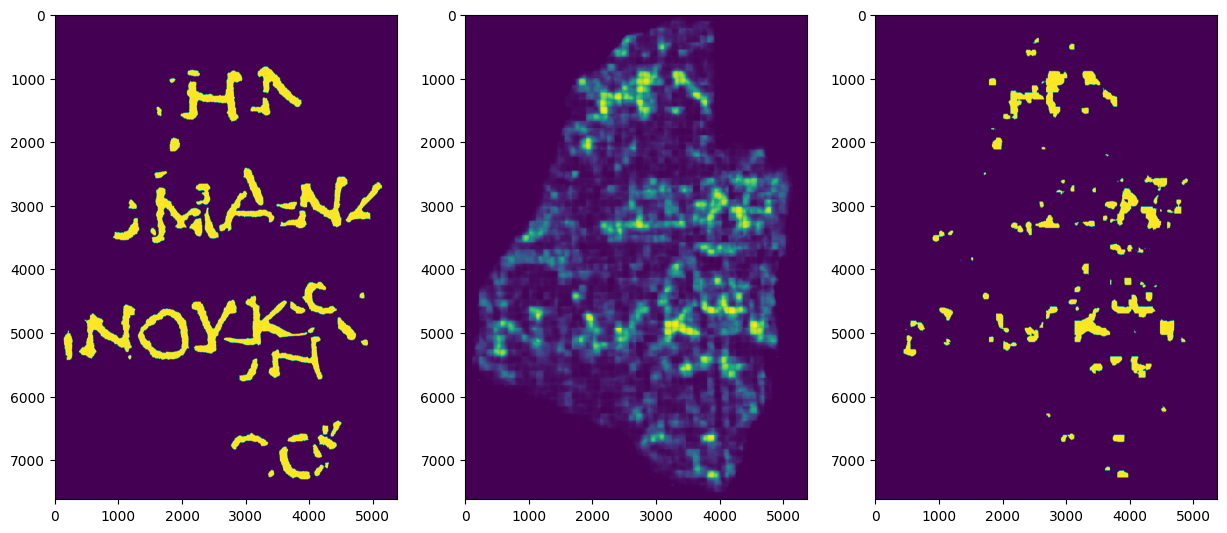

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([24363415.,  5044805.,  2894902.,  1941618.,  1408145.,  1061817.,
          814949.,   634501.,   505345.,   389304.,   309759.,   281833.,
          243418.,   215784.,   196436.,   173885.,   153257.,   139131.,
          117918.,    53394.]),
 array([1.26953990e-13, 4.95775983e-02, 9.91551965e-02, 1.48732795e-01,
        1.98310393e-01, 2.47887991e-01, 2.97465590e-01, 3.47043188e-01,
        3.96620786e-01, 4.46198384e-01, 4.95775983e-01, 5.45353581e-01,
        5.94931179e-01, 6.44508778e-01, 6.94086376e-01, 7.43663974e-01,
        7.93241572e-01, 8.42819171e-01, 8.92396769e-01, 9.41974367e-01,
        9.91551965e-01]),
 <BarContainer object of 20 artists>)

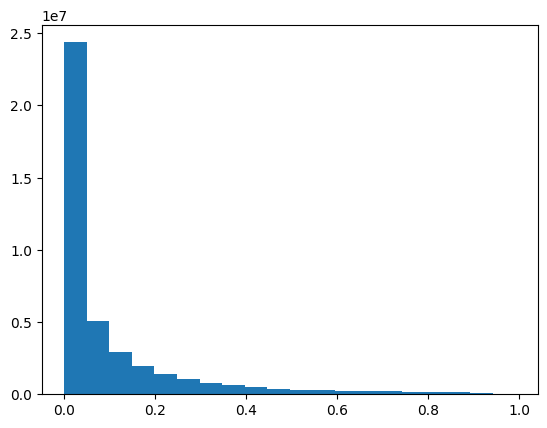

In [34]:
plt.hist(mask_pred.flatten(), bins=20)